Цель - предсказать пола клиента по транзакциям.

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

In [60]:
!git clone https://github.com/alexey9019/data.git

fatal: destination path 'data' already exists and is not an empty directory.


In [0]:
tr_mcc_codes = pd.read_csv('/content/data/tr_mcc_codes.csv', sep = ';', index_col = 'mcc_code')
tr_types = pd.read_csv('/content/data/tr_types.csv', sep = ';', index_col = 'tr_type')
transactions = pd.read_csv('/content/data/transactions.csv', index_col = 'customer_id')
gender_train = pd.read_csv('/content/data/gender_train.csv', index_col = 'customer_id')
gender_test = pd.read_csv('/content/data/gender_test.csv', index_col = 'customer_id')

transactions_train = transactions.join(gender_train, how = 'inner')
transactions_test = transactions.join(gender_test, how = 'inner')

In [0]:
# создадим функции для построения классификатора 
# оценим результаты и построим прогноз для тестовых пользователей
# cv_score - cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)
def cv_score(params, train, y_true):
    cv_res = xgb.cv(params, xgb.DMatrix(train, y_true),
               early_stopping_rounds = 10, maximize = True, 
               num_boost_round = 10000, nfold = 5, stratified = True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-vali hi dation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                     cv_res.loc[index_argmax]['test-auc-std'],
                                                                     index_argmax))

# построим модель и выведем результаты классификации тестовых пользователей
def fit_predict(params, num_trees, train, test, target):
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names = list(train.columns)), 
              num_boost_round = num_trees, maximize = True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names = list(train.columns)))
    submission = pd.DataFrame(index = test.index, data = y_pred, columns = ['probability'])
    return clf, submission

# отобразим важность переменной
def draw_feature_importances(clf, top_k = 10):
    plt.figure(figsize = (10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key = lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align = 'center', color = 'red')
    plt.yticks(y_pos, importances.keys(), fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.title('Важность переменной', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

In [0]:
# зададим параметры
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

In [0]:
# используем медиану, среднеквадратичное отклонение и количество
def features_creation_basic(x): 
    features = []
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)

data_train = transactions_train.groupby(transactions_train.index).apply(features_creation_basic)
data_test = transactions_test.groupby(transactions_test.index).apply(features_creation_basic)

In [65]:
# выведем результат
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

Cross-vali hi dation, ROC AUC: 0.611+-0.064, Trees: 50


In [0]:
# результат классификации тестовых пользователей
clf, submission = fit_predict(params, 70, data_train, data_test, target)

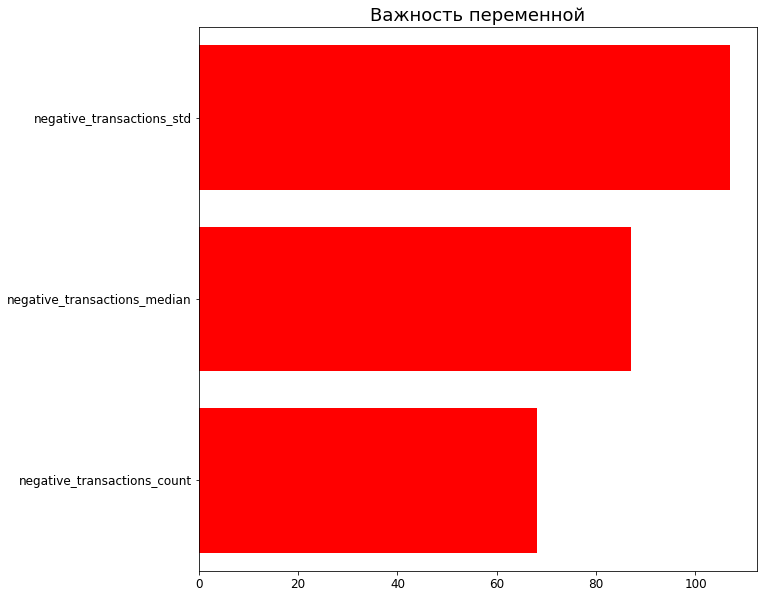

In [67]:
# отобразим важность переменной
draw_feature_importances(clf, 10)

In [0]:
# сохраним в файл
submission.to_csv('/content/data/basic_features_submission.csv')

In [0]:
# используем данные о том, где совершались транзакции
# предполагаем, что мужчины чаще будут покупать цветы (mcc_code 5992 - флористика)
for df in [transactions_train, transactions_test]:
    df['mcc_code'] == 5992
    df['mcc'] = df['mcc_code']

In [0]:
# используем медиану, среднеквадратичное отклонение и количество
def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['mcc_code'].value_counts(normalize = True).add_prefix('mcc_code_')))
    features.append(pd.Series(x['mcc'].value_counts(normalize = True).add_prefix('mcc_')))
    
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    
    return pd.concat(features)

In [0]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .apply(features_creation_advanced).unstack(-1)

In [71]:
# выведем результат
target = data_train.join(gender_train, how = 'inner')['gender']
cv_score(params, data_train, target)

Cross-vali hi dation, ROC AUC: 0.808+-0.075, Trees: 38


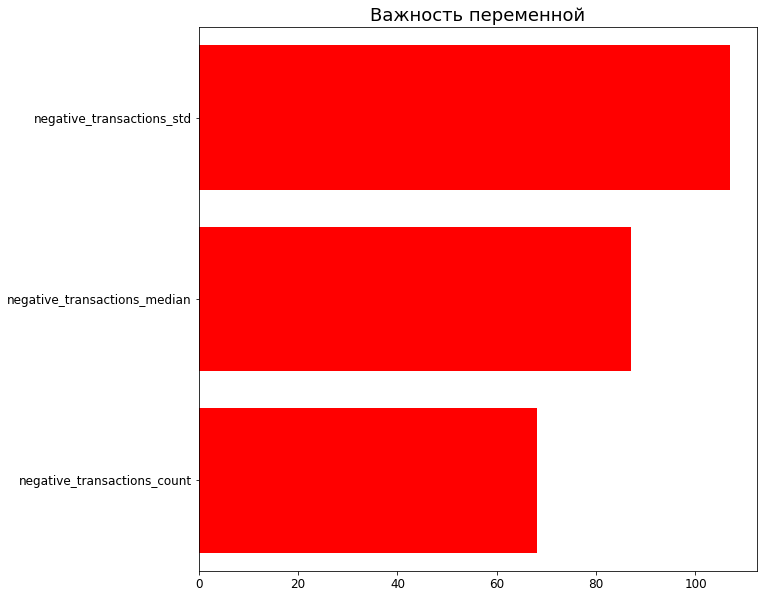

In [20]:
# отобразим важность переменной
draw_feature_importances(clf, 10)

In [0]:
# сохраним в файл
submission.to_csv('/content/data/submission_advanced.csv')

In [73]:
transactions_train.drop(['tr_datetime', 'term_id'], axis = 1, inplace=True)
transactions_train.head()

,mcc_code,tr_type,amount,gender,mcc
customer_id,,,,,
600423,5411,1110,-5773.35,0,5411
600423,6011,2010,-11229.58,0,6011
600423,6011,2010,-67377.47,0,6011
600423,5411,1110,-2616.49,0,5411
600423,6011,2010,-22459.16,0,6011


In [74]:
transactions_train.describe()

,mcc_code,tr_type,amount,gender,mcc
count,61439.000000,61439.000000,6.143900e+04,61439.000000,61439.000000
mean,5582.150865,2191.452595,-3.023813e+04,0.552808,5582.150865
std,617.691250,2015.563063,5.055619e+05,0.497207,617.691250
min,1711.000000,1010.000000,-5.140376e+07,0.000000,1711.000000
25%,5331.000000,1010.000000,-2.919691e+04,0.000000,5331.000000
50%,5541.000000,1110.000000,-7.905620e+03,1.000000,5541.000000
75%,6010.000000,2011.000000,-2.245920e+03,1.000000,6010.000000
max,9399.000000,8145.000000,3.593465e+07,1.000000,9399.000000


In [75]:
transactions_train.dtypes

mcc_code      int64
tr_type       int64
amount      float64
gender        int64
mcc           int64
dtype: object

In [76]:
transactions_train['gender'].value_counts()

1    33964
0    27475
Name: gender, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faeeeb1f400>,
      dtype=object)

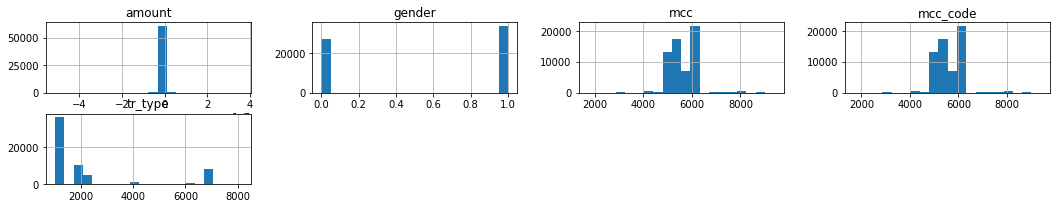

In [77]:
transactions_train.hist(figsize=(18, 8), layout=(5,4), bins=20)

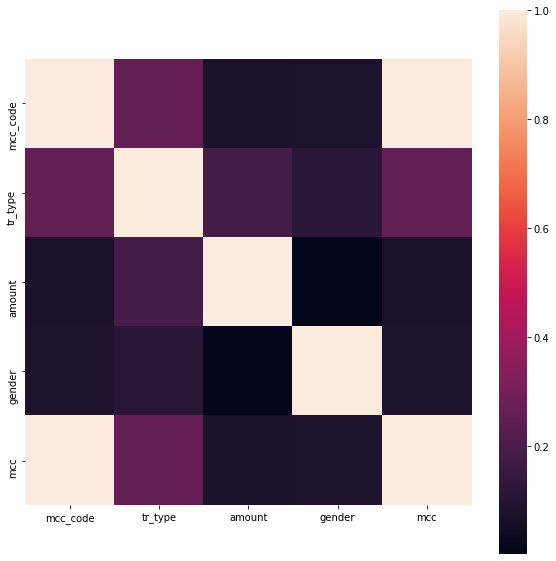

In [78]:
plt.subplots(figsize=(10,10))
sns.heatmap(transactions_train.corr(), square=True)
plt.show()

In [79]:
X = transactions_train.values.astype(np.float)
X

array([[ 5.411000e+03,  1.110000e+03, -5.773350e+03,  0.000000e+00,
         5.411000e+03],
       [ 6.011000e+03,  2.010000e+03, -1.122958e+04,  0.000000e+00,
         6.011000e+03],
       [ 6.011000e+03,  2.010000e+03, -6.737747e+04,  0.000000e+00,
         6.011000e+03],
       ...,
       [ 5.211000e+03,  1.110000e+03, -1.010662e+04,  1.000000e+00,
         5.211000e+03],
       [ 5.499000e+03,  1.010000e+03, -1.670961e+04,  1.000000e+00,
         5.499000e+03],
       [ 5.311000e+03,  1.110000e+03, -1.701506e+04,  1.000000e+00,
         5.311000e+03]])

In [80]:
scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.27708383, -0.53655547,  0.04839166, -1.11183557, -0.27708383],
       [ 0.69428315, -0.09002649,  0.03759917, -1.11183557,  0.69428315],
       [ 0.69428315, -0.09002649, -0.07346212, -1.11183557,  0.69428315],
       ...,
       [-0.60087282, -0.53655547,  0.0398204 ,  0.89941357, -0.60087282],
       [-0.13461667, -0.58616981,  0.02675959,  0.89941357, -0.13461667],
       [-0.43897833, -0.53655547,  0.02615541,  0.89941357, -0.43897833]])

In [0]:
y = transactions_train['gender'].map({True: 1, False: 0}).values

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, random_state=42)

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_grid = {'n_neighbors': np.array(np.linspace(1, 100, 100), dtype='int')}
gs = GridSearchCV(knn, knn_grid, cv=5)
gs.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [0]:
def grid_plot(x, y, x_label, title, y_label='accuracy'):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

In [0]:
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [0]:
print(gs.best_params_, gs.best_score_)

In [0]:
knn = KNeighborsClassifier(n_neighbors=25) 
clf_knn = knn.fit(X_train, y_train)

In [0]:
y_knn = clf_knn.predict(X_test)
y_knn

In [0]:
print(sklearn.metrics.classification_report(y_test, y_knn))

In [0]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

In [0]:
predictions = regr.predict(X_test)
predictions

In [0]:
rem = predictions - y_test
plt.figure(figsize=(15, 8))
plt.hist(rem, bins=50, normed=True)

In [0]:
r2 = sklearn.metrics.r2_score(y_test, predictions)

print(f"R2 score / LR = {r2}")

In [0]:
mae = sklearn.metrics.median_absolute_error(y_test, predictions)

print (f"MAE {mae}")